## imports

In [85]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch

from stable_baselines3 import DQN

print("tout est installé")


tout est installé


In [86]:
import sys, os
sys.path.append(os.path.abspath(".."))  # pour importer src/ depuis notebooks/

from src.env.frozenlake_env import make_frozenlake, FrozenLakeConfig
import matplotlib.pyplot as plt

from src.env.frozenlake_env import make_frozenlake, FrozenLakeConfig
from src.algorithms.q_learning import q_learning

In [87]:
def quick_check(cfg: FrozenLakeConfig, n_steps=10):
    env = make_frozenlake(cfg)
    obs, info = env.reset()
    for _ in range(n_steps):
        a = env.action_space.sample()
        obs, r, terminated, truncated, info = env.step(a)
        if terminated or truncated:
            obs, info = env.reset()
    env.close()
    return "OK"

tests = [
    FrozenLakeConfig(map_name="4x4", is_slippery=True,  shaped=False, seed=0),
    FrozenLakeConfig(map_name="4x4", is_slippery=False, shaped=False, seed=0),
    FrozenLakeConfig(map_name="8x8", is_slippery=True,  shaped=False, seed=0),
    FrozenLakeConfig(map_name="8x8", is_slippery=True,  shaped=True,  seed=0),
]

for t in tests:
    print(t, "->", quick_check(t))


FrozenLakeConfig(map_name='4x4', desc=None, is_slippery=True, max_episode_steps=200, shaped=False, step_penalty=-0.001, hole_penalty=-0.05, goal_bonus=1.0, seed=0) -> OK
FrozenLakeConfig(map_name='4x4', desc=None, is_slippery=False, max_episode_steps=200, shaped=False, step_penalty=-0.001, hole_penalty=-0.05, goal_bonus=1.0, seed=0) -> OK
FrozenLakeConfig(map_name='8x8', desc=None, is_slippery=True, max_episode_steps=200, shaped=False, step_penalty=-0.001, hole_penalty=-0.05, goal_bonus=1.0, seed=0) -> OK
FrozenLakeConfig(map_name='8x8', desc=None, is_slippery=True, max_episode_steps=200, shaped=True, step_penalty=-0.001, hole_penalty=-0.05, goal_bonus=1.0, seed=0) -> OK


### Créer l’environnement (baseline)

In [88]:
cfg = FrozenLakeConfig(
    map_name="4x4",
    is_slippery=True,
    shaped=False,
    seed=42,
)

env = make_frozenlake(cfg)


### Entraînement Q-Learning

In [89]:
Q, rewards_q = q_learning(
    env,
    n_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
    seed=42,
)

print("Entraînement Q-Learning terminé")
print("Récompense moyenne (100 derniers épisodes) :", 
      np.mean(rewards_q[-100:]))


Entraînement Q-Learning terminé
Récompense moyenne (100 derniers épisodes) : 0.41


### Sauvegarde des résultats

In [90]:
import os

os.makedirs("../results/rewards", exist_ok=True)

np.save("../results/rewards/q_learning_rewards.npy", rewards_q)
np.save("../results/models/q_learning_Q.npy", Q)


### Courbe d’apprentissage

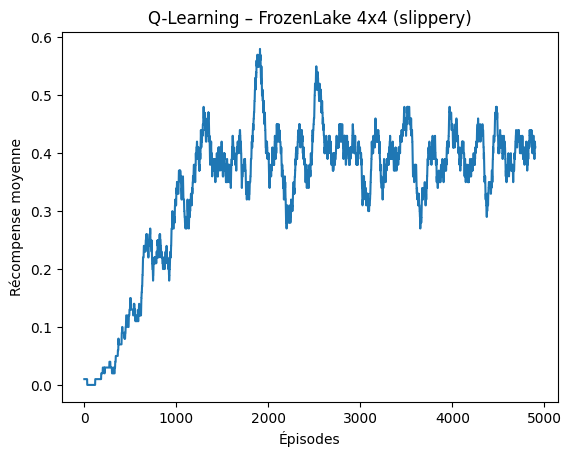

In [91]:
def moving_average(x, window=100):
    return np.convolve(x, np.ones(window) / window, mode="valid")

plt.figure()
plt.plot(moving_average(rewards_q))
plt.xlabel("Épisodes")
plt.ylabel("Récompense moyenne")
plt.title("Q-Learning – FrozenLake 4x4 (slippery)")
plt.show()


Q-Learning converge mais reste sensible à la stochasticité, ce qui justifie la comparaison avec SARSA et DQN.

### fonction “watch” tabulaire

In [92]:
import gymnasium as gym
import numpy as np
import time

def watch_tabular_agent(Q, map_name="4x4", is_slippery=True, seed=0, sleep=0.35, max_steps=200):
    """
    Affiche un épisode dans une fenêtre avec render_mode='human'
    Q : Q-table (n_states, n_actions)
    """
    env = gym.make(
        "FrozenLake-v1",
        map_name=map_name,
        is_slippery=is_slippery,
        render_mode="human",
    )

    obs, _ = env.reset(seed=seed)
    done = False
    steps = 0
    total_reward = 0.0

    while not done and steps < max_steps:
        action = int(np.argmax(Q[obs]))
        obs, r, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += r
        steps += 1
        time.sleep(sleep)

    env.close()
    print(f"Episode terminé | steps={steps} | total_reward={total_reward}")


####  Q = table Q apprise par Q-learning

In [93]:
watch_tabular_agent(Q, map_name="4x4", is_slippery=True, seed=0)


Episode terminé | steps=17 | total_reward=0.0


### Sarsa

In [94]:
from src.algorithms.sarsa import sarsa


### Entraînement SARSA

In [95]:
Q_sarsa, rewards_sarsa = sarsa(
    env,
    n_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
    seed=42,
)

print("Entraînement SARSA terminé")
print("Récompense moyenne (100 derniers épisodes) :", 
      np.mean(rewards_sarsa[-100:]))


Entraînement SARSA terminé
Récompense moyenne (100 derniers épisodes) : 0.28


### Sauvegarde

In [96]:
import os
os.makedirs("../results/rewards", exist_ok=True)

np.save("../results/rewards/sarsa_rewards.npy", rewards_sarsa)
np.save("../results/models/sarsa_Q.npy", Q_sarsa)


### Comparaison visuelle Q-Learning vs SARSA

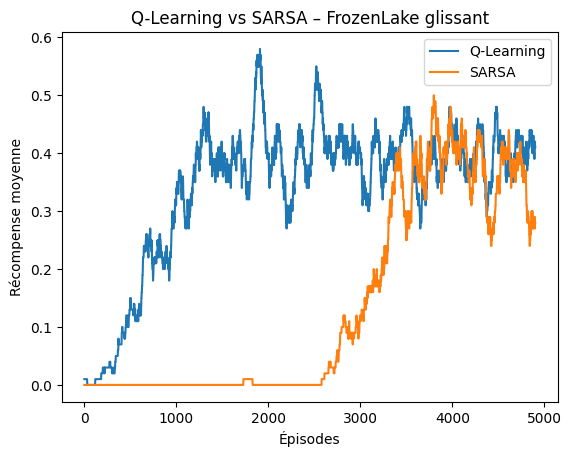

In [97]:
def moving_average(x, window=100):
    return np.convolve(x, np.ones(window) / window, mode="valid")

plt.figure()
plt.plot(moving_average(rewards_q), label="Q-Learning")
plt.plot(moving_average(rewards_sarsa), label="SARSA")
plt.xlabel("Épisodes")
plt.ylabel("Récompense moyenne")
plt.title("Q-Learning vs SARSA – FrozenLake glissant")
plt.legend()
plt.show()


SARSA adopte une stratégie plus conservatrice que Q-Learning.
Dans un environnement stochastique comme FrozenLake glissant, SARSA présente une convergence plus stable mais une performance finale légèrement inférieur

In [98]:
watch_tabular_agent(Q_sarsa, map_name="4x4", is_slippery=True, seed=0)

Episode terminé | steps=17 | total_reward=0.0


In [99]:
from src.algorithms.dqn import train_dqn


In [100]:
cfg_dqn = FrozenLakeConfig(
    map_name="4x4",
    is_slippery=True,
    shaped=True,      # important pour DQN
    seed=42,
)

env_dqn = make_frozenlake(cfg_dqn)


### train dqn

In [101]:
dqn_model = train_dqn(
    env_dqn,
    total_timesteps=50000,
)


Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.75     |
|    ep_rew_mean      | -0.0577  |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1032     |
|    time_elapsed     | 0        |
|    total_timesteps  | 31       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11       |
|    ep_rew_mean      | -0.061   |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1281     |
|    time_elapsed     | 0        |
|    total_timesteps  | 88       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.58     |
|    ep_rew_mean      | -0.0596  |
|    exploration_rate | 0.989    |
| time/               |          |
|  

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.94     |
|    ep_rew_mean      | -0.0599  |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 1325     |
|    time_elapsed     | 0        |
|    total_timesteps  | 159      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.2      |
|    ep_rew_mean      | -0.0592  |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 1290     |
|    time_elapsed     | 0        |
|    total_timesteps  | 184      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.96     |
|    ep_rew_mean      | 0.0265   |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes       

### Évaluation du DQN

Récompense moyenne DQN sur 5000 épisodes : 0.43


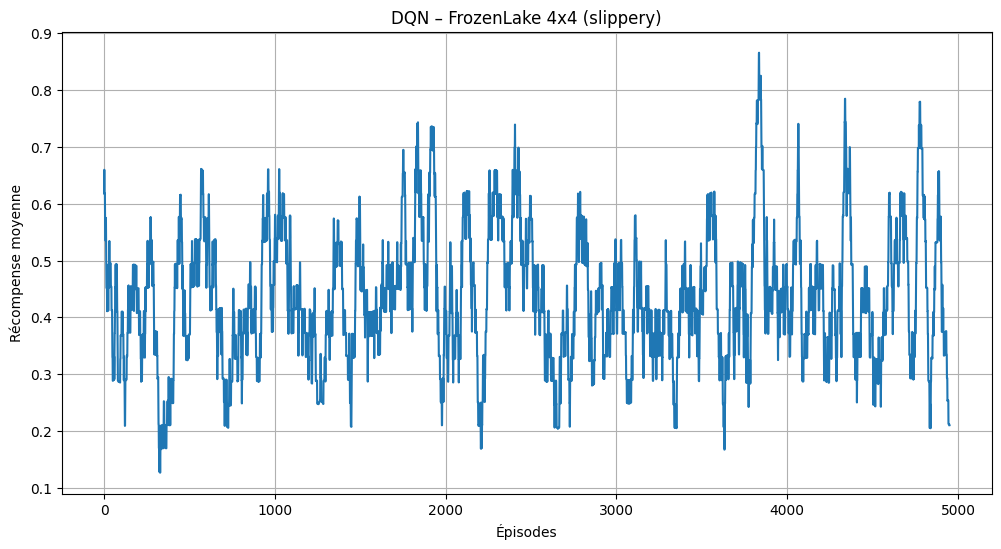

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour moyenne glissante
def moving_average(x, window=100):
    return np.convolve(x, np.ones(window)/window, mode='valid')

# Fonction d'évaluation DQN
def evaluate_dqn(model, env, n_episodes=5000):
    rewards = []

    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)
            obs, reward, terminated, truncated, _ = env.step(action)
            obs = int(obs)
            done = terminated or truncated
            total_reward += reward

        rewards.append(total_reward)

    mean_reward = np.mean(rewards)
    print(f"Récompense moyenne DQN sur {n_episodes} épisodes : {mean_reward:.2f}")
    return rewards

# Évaluer le modèle et récupérer les récompenses
rewards_dqn = evaluate_dqn(dqn_model, env_dqn, n_episodes=5000)

# Tracer la moyenne glissante
plt.figure(figsize=(12,6))
plt.plot(moving_average(rewards_dqn, window=50))
plt.xlabel("Épisodes")
plt.ylabel("Récompense moyenne")
plt.title("DQN – FrozenLake 4x4 (slippery)")
plt.grid(True)
plt.show()


### comparaison les 3 algorithms

Récompense moyenne DQN sur 5000 épisodes : 0.43


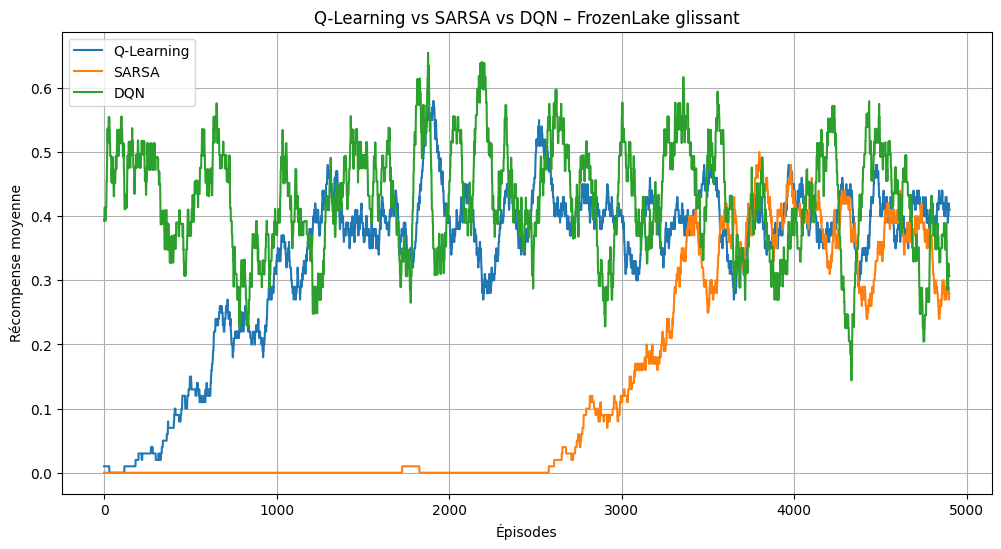

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction moyenne glissante
def moving_average(x, window=100):
    return np.convolve(x, np.ones(window)/window, mode='valid')

# Fonction d'évaluation DQN
def evaluate_dqn(model, env, n_episodes=5000):
    rewards = []

    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)
            obs, reward, terminated, truncated, _ = env.step(action)
            obs = int(obs)
            done = terminated or truncated
            total_reward += reward

        rewards.append(total_reward)

    mean_reward = np.mean(rewards)
    print(f"Récompense moyenne DQN sur {n_episodes} épisodes : {mean_reward:.2f}")
    return rewards

# Évaluer le modèle DQN
rewards_dqn = evaluate_dqn(dqn_model, env_dqn, n_episodes=5000)

# Tracer la comparaison
plt.figure(figsize=(12,6))
plt.plot(moving_average(rewards_q), label="Q-Learning")
plt.plot(moving_average(rewards_sarsa), label="SARSA")
plt.plot(moving_average(rewards_dqn), label="DQN")
plt.xlabel("Épisodes")
plt.ylabel("Récompense moyenne")
plt.title("Q-Learning vs SARSA vs DQN – FrozenLake glissant")
plt.legend()
plt.grid(True)
plt.show()


### Sauvegarde du modèle

In [104]:
import os
os.makedirs("../results/models", exist_ok=True)

dqn_model.save("../results/models/dqn_frozenlake")
np.save("../results/rewards/dqn_rewards.npy", rewards_dqn)


In [105]:
import numpy as np

rewards_q = np.load("../results/rewards/q_learning_rewards.npy")
rewards_sarsa = np.load("../results/rewards/sarsa_rewards.npy")
dqn_rewards = np.load("../results/rewards/dqn_rewards.npy")

### final mean reward

In [106]:
def final_mean_reward(rewards, last_n=100):
    return float(np.mean(rewards[-last_n:]))

print("Q-Learning :", final_mean_reward(rewards_q))
print("SARSA     :", final_mean_reward(rewards_sarsa))
print("DQN       :", float(np.mean(dqn_rewards)))


Q-Learning : 0.41
SARSA     : 0.28
DQN       : 0.426066


### Variance

In [107]:
print("Variance Q-Learning :", np.var(rewards_q[-500:]))
print("Variance SARSA     :", np.var(rewards_sarsa[-500:]))
print("Variance DQN       :", np.var(dqn_rewards[-500:]))


Variance Q-Learning : 0.24039600000000003
Variance SARSA     : 0.22809599999999997
Variance DQN       : 0.7501040526840002


In [108]:
import gymnasium as gym
from src.env.frozenlake_env import FrozenLakeConfig, make_frozenlake

cfg_render = FrozenLakeConfig(
    map_name="4x4",
    is_slippery=True,
    shaped=False,
    seed=0,
)

env_render = gym.make(
    "FrozenLake-v1",
    map_name=cfg_render.map_name,
    is_slippery=cfg_render.is_slippery,
    render_mode="human",
)


### Watch dqn

In [109]:
def watch_dqn_agent(model, map_name="4x4", is_slippery=True, seed=0, sleep=0.35, max_steps=200):
    env = gym.make(
        "FrozenLake-v1",
        map_name=map_name,
        is_slippery=is_slippery,
        render_mode="human",
    )

    obs, _ = env.reset(seed=seed)
    done = False
    steps = 0
    total_reward = 0.0

    while not done and steps < max_steps:
        action, _ = model.predict(obs, deterministic=True)
        obs, r, terminated, truncated, _ = env.step(int(action))
        done = terminated or truncated
        total_reward += r
        steps += 1
        time.sleep(sleep)

    env.close()
    print(f"Episode terminé | steps={steps} | total_reward={total_reward}")


In [110]:
watch_dqn_agent(dqn_model, map_name="4x4", is_slippery=True, seed=0)


Episode terminé | steps=18 | total_reward=1.0
